# install a helper package to read our model, will be replaced soon

In [12]:
!pip install cayenne

Note: you may need to restart the kernel to use updated packages.


# import all the libraries

In [13]:
from math import e
import matplotlib
import numpy as np, argparse, sys, random, os
from os import path
from utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cayenne.simulation import Simulation
import time
from tqdm import tqdm
import numpy as np
import seaborn as sns

# define model

In [14]:
CO_Oxidation_no_vape = """
        const compartment comp1;
        comp1 = 1; # volume of compartment
        r1: CO_g + E => CO_s; k1;
        r2: O2_g + 2E => 2O_s; k2;
        r3: CO_s + O_s => CO2_g + 2E; k3;
        k1 = 5.78e5;
        k2 = 1.62e5;
        
        CO_g = 0;
        CO_s = 1;
        E = 1;
        O2_g = 0;
        O_s = 1;
        CO2_g = 0;
        chem_flag = true;
        k3 = 1.71e2;
    """


# define iterations, simulation will stop if reaches max iters or gamma_total reaches zero 

In [5]:
max_iter = int(5e4)

# load the model string and create sim object

In [6]:
sim = Simulation.load_model(CO_Oxidation_no_vape, "ModelString")

# define lattice

In [7]:
n = 56
idx_empty = sim.species_names.index("E")
lattice = np.full(shape=(n,n), fill_value=idx_empty, dtype=int)

# Plot related settings

In [8]:
plot_title = 'CO Oxidation'
# list to store recorded data
data_record = [[0] for _ in range(len(sim.species_names))]
# for now we assume inital condition is all empty
data_record[idx_empty] = [n * n]
# time records
t_data = [0]
# cumulated time among iterations 
cumu_time = 0
# define at which iter you would like to generate a heatmap. We can only estimate how many iters a simualtion is consists of
heatmap_iters = [2000, 4000]

# Initialize epsilon, N_j, and Gamma_total

In [9]:
e_0 = np.full(shape=(n,n), fill_value=0, dtype=int)
E = [copy.deepcopy(e_0) for _ in range(len(sim.rxn_names))]
for i in range(n):
    for j in range(n):
        neighbours = check_neighbours(i, j, n)
        neighbours_id = position_to_id(neighbours, lattice)
        e = get_react_candidate(sim._react_stoic, sim._init_state, lattice[i, j], neighbours_id, idx_empty)
        for item in e:
            E[item][i,j] = 1
N_j = [0 for _ in range(len(sim.rxn_names))]
for j in range(len(sim.rxn_names)):
    x = sum(sum(E[j]))
    N_j[j] = x
E_gamma = copy.deepcopy(E)
for j in range(len(sim.rxn_names)):
    E_gamma[j] *= int(sim._k_det[j])
Gamma_total = sum(sum(sum(E_gamma)))

# Main loop

  4%|▎         | 1768/50001 [00:00<00:16, 2994.97it/s]

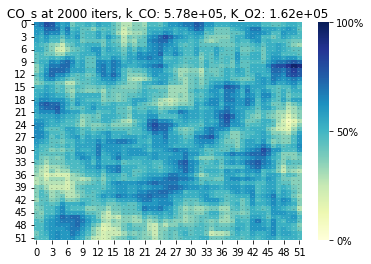

  8%|▊         | 3981/50001 [00:09<00:56, 808.86it/s]

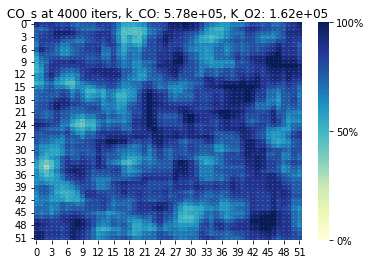

 15%|█▍        | 7331/50001 [00:18<01:47, 395.39it/s] 

no avaialable reaction


<Figure size 432x288 with 0 Axes>

In [10]:
for i in tqdm(range(max_iter+1)):
    if Gamma_total <= 0:
        print("no avaialable reaction")
        break
    t_data.append(cumu_time)
    row, col, reaction_idx = generate_site(n, sim, E, Gamma_total, N_j)
    r2 = random.uniform(0, 1)

    cumu_time += -np.log(r2)/Gamma_total

    # get all neighbours with predefined order (up, right, down, left)
    neighbours = check_neighbours(row, col, n)
    # also create a random version
    neighbours_random = neighbours.copy()
    neighbours_random = neighbours_random[1:]
    random.shuffle(neighbours_random)
    neighbours_random.insert(0, neighbours[0])
    
    neighbours_id = position_to_id(neighbours, lattice)
    update_records(data_record, i)
    change_log = update_events(sim._react_stoic[:,reaction_idx], sim._prod_stoic[:,reaction_idx], lattice, neighbours_random, sim._init_state, data_record, i)
    
    change_cand = []
    for rowp, colp in change_log:
        neighbours = check_neighbours(rowp, colp, n)
        for item in neighbours:
            if item not in change_cand:
                change_cand.append(item)

    for rowpp, colpp in change_cand:
        # we let all candidates be 0 first, then decide their E
        for indx in range(len(E)):
            if E[indx][rowpp,colpp] == 1:
                E[indx][rowpp,colpp] = 0
                N_j[indx] -= 1
                Gamma_total -= 1 * sim._k_det[indx]
        neighbours = check_neighbours(rowpp, colpp, n)
        neighbours_id = position_to_id(neighbours, lattice)
        e = get_react_candidate(sim._react_stoic, sim._init_state, lattice[rowpp, colpp], neighbours_id, idx_empty)
        for rx in e:
            if E[rx][rowpp,colpp] != 1:
                E[rx][rowpp,colpp] = 1
                N_j[rx] += 1
                Gamma_total += 1 * sim._k_det[rx]
    
    if i in heatmap_iters:
        filtered_mat = create_filtered_mat(lattice, n, filter_size=5)
        # data = np.random.rand(8, 12)
        ax = sns.heatmap(filtered_mat, annot=True, annot_kws={"fontsize":1}, vmin=0, vmax=1, cmap="YlGnBu")
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0, .5, 1])
        cbar.set_ticklabels(['0%', '50%', '100%'])
        ax.set_title("CO_s at {} iters, k_CO: {:.2e}, K_O2: {:.2e}".format(i, sim._k_det[0], sim._k_det[1]))
        plt.show()
        plt.savefig('heat_{}_k_CO_{:.2e}.pdf'.format(i, sim._k_det[0]))
        plt.clf()


# Plot the graph while the simulation ends

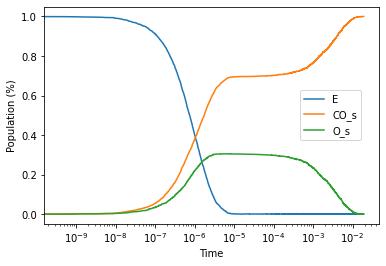

<Figure size 432x288 with 0 Axes>

In [11]:
for i in range(len(data_record)):
  if sim._init_state[i] != 0:
    quotients = [number / (n*n) for number in data_record[i]]
    plt.plot(t_data, quotients, marker="", label=sim.species_names[i])

plt.xlabel("Time")
plt.ylabel("Population (%)")
plt.legend(bbox_to_anchor=(0.75, 0.5), loc='center left')
######### log time scale, comment out if not needed
plt.xscale("log")
#########
plt.show()
plt.savefig('test.png')